# Sofia's PyAstronomy Tutorial

## Big Picture: What we're trying to accomplish

For the [DRD] (Drift Rate Distribution) project, we want a distribution of all drift rates throughout an exoplanet's orbit, for all known exoplanets, corrected for known detection biases. 

The first step in that is to work out the drift rates produced by a single exoplanetary system, and create a distribution of that. 

The next step is to play around with input parameters, to get an idea of how changes in different parameters affect the drift rate distributions that we observe. We will use this as a "proof-of-concept" as well, to make sure that the plots we're getting line up with our intuition!

## Python Packages: PyAstronomy

To accomplish a lot of the ellipse geometry, I wanted to make use of a pre-existing package so we didn't have to start from scratch. Here, I decided upon PyAstronomy --- it isn't a huge package, but it does have a great pre-written [Keplerian 2-body orbit function](https://pyastronomy.readthedocs.io/en/latest/pyaslDoc/aslDoc/keplerOrbit.html). That link is to the documentation, which is how I learned the package over the last week!

To start, you'll need to install PyAstronomy on your laptop, if you're using Jupyter locally. If you're using it on one of the BL servers, the process should be similar. In a terminal, type `pip install pyastronomy`. All that said, if you're instead using a Colab Notebook, I'm not 100% sure how package installation works. You might be able to skip installation and jump straight to `from PyAstronomy import pyasl` below.

## PyAstronomy Example: Modelling the Orbit of a Fictional Planet

### Package Imports

First thing's first: package imports and other configuration, whooo! The cell below will set up your matplotlib to run in a "notebook" mode, which has some really neat interactive features that are especially useful when working with 3D data (like our orbit plots will be). Sometimes, it's a bit buggy though. If you're having issues with plots further down in the notebook, you can sometimes "refresh" matplotlib by rerunning the cell below.

In [1]:
%matplotlib notebook

Now we're going to import a slew of useful packages. numpy and matplotlib.pyplot are super useful everyday standards. I also selected a few specific routines out of astropy (units and constants) to help us manage the more book-keep-y elements of the physics, as well as an additional routine from matplotlib because it was being dumb about the 3D plotting. And of course, we're going to import PyAstronomy! Or, specifically, the module within PyAstronomy that will do Kepler ellipses for us.

In [2]:
#general utility packages
import numpy as np
import matplotlib.pyplot as plt

#nice modules from astropy
import astropy.units as u
import astropy.constants as const

#remind matplotlib how to do 3D plotting
from mpl_toolkits.mplot3d import Axes3D

#PyAstronomy Kepler module!
from PyAstronomy import pyasl

And, just because it will be useful later, let's have astropy define some constants for us:

In [3]:
G = const.G
c = const.c

### Defining an Ellipse Object

Great, now let's get coding! First, let's define the parameters we want for our model exoplanetary system. 

Remember that, usually, it takes the following information to define an orbit:
- Eccentricity (e): How elliptical is your ellipse? (between 0-1, unitless)
- Semi-major Axis (a): How far away is the planet orbiting from its host star? (a distance)
- Inclination (i): From Earth's perspective, a rotation around the x-axis. Is the Earth "face-on" (0 degrees) or "edge-on" (+-90 degrees) (an angle)
- Longitude of Ascending Node (omega): From Earth's perspective, a rotation around the z-axis (0-360 degrees, an angle)
- Argument of Periapsis (w): Once you get the orbital plane from i and omega, this tells you how the ellipse is rotated (0-360 degrees, an angle)
- Some time argument: could be mean anomaly, true anomaly and an epoch... it just defines where the planet "starts" in its orbit. For us it doesn't really matter, as we're going to trace out exactly one orbital period, no more, no less.

At this point, it might be good to click over to the PyAstronomy documentation page for the Keplerian orbit module --- [here it is again](https://pyastronomy.readthedocs.io/en/latest/pyaslDoc/aslDoc/keplerOrbit.html). Read through the "Orbital elements and orientation of the orbit" section. You don't need to fully understand all of it now. But hopefully, especially in combination with our discussion on Keplerian Orbital Elements, you'll know what words to use and where to find answers if you have a question about how your code is treating any of these parameters. *Especially* once we start combining the exoplanet catalogs with this code.

For this code, we don't need to provide a time argument (great, as we didn't need it anyway) but they want both the semimajor axis and the period. Presumably, somewhere, they use it to calculate the mass of the central star? All that means for us is we'll also need to add the period in years to our input parameters.

I'm going to put in example parameters for a Earth around a Sun, seen edge-on in its orbit but with no other rotations.

In [31]:
#the Kepler Ellipse package requires the following units to be used 
#but does NOT like units being added via astropy - had to comment them out

#details of the system
period_years = 1 #* u.year
semimajor_au = 1 #* u.AU
eccentricity = 0.05

#details of system's orientation relative to Earth
inclination = 90 #* u.deg
argument_of_periapse = 0 #* u.deg
longitude_of_ascending_node = 0 #* u.deg

#adding in the mass because we'll want it later
stellar_mass = 1 * u.Msun

It's ellipse time! The next cell will create a Kepler Ellipse object based on our parameters.

In [32]:
ke = pyasl.KeplerEllipse(semimajor_au, 
                         period_years, 
                         e=eccentricity, 
                         Omega=longitude_of_ascending_node, 
                         i=inclination, 
                         w=argument_of_periapse)

### Sampling Positions of the Ellipse Object

Now we need to take that abstract geometric object it just made and get some actual values out of it. To do this, we need to tell PyAstronomy how many timesteps we want the code to use. Basically, this just defines how many samples we want to take over a single orbit. Too few, and you'll only have a couple data points, probably missing important times like periapse. Too many, and your computer will run forever. Their example uses 200, which seems like a good starting number - we can adjust this up or down as we explore the code and try modeling different systems.

In [33]:
num_timesteps = 200

# Make a time axis
t = np.linspace(0, period_years, num_timesteps)

Cool, now we can ask PyAstronomy to sample our ellipse at 200 equally-spaced times.

In [34]:
# Calculate the orbit position at the given points in a Cartesian coordinate system.
pos = ke.xyzPos(t)

We now have an array of orbit positions for our ellipse. You'll notice from the following print statements that the array consists of `num_timesteps` entries, each with three associated numbers: an x, y, and z position in AU, where (0,0,0) is the central star (I think? need to check this).

In [52]:
print("Shape of output array: ", pos.shape)
# x, y, and z coordinates for 50th time point
print("x, y, z for 50th point: ", pos[50, ::])

Shape of output array:  (200, 3)
x, y, z for 50th point:  [-1.07777728e-01  6.10535892e-17  9.97080779e-01]


### Visualizing our positions

Now we can make some plots of our nicely sampled orbit, both from the perspective of an observer on Earth and as a 3D interactive plot

A few notes: 

- I have used plt.xlim (for the top plot) and ax.set_xlim (for the bottom plot) to constrain the x-axis. I did the same for y and z. This is because matplotlib kept SUPERZOOMING on the y-axis by default, making the edge-on orbit look like a circle instead of a line in the first plot. Make sure to check your axes whenever you plot, and add or remove the axes limits when applicable.
- 3D interactive plots are very fun in Jupyter! Zoom in and out! Rotate the plot! Save screenshots with ease! This is a good time to tinker with those features to learn them for the future

<IPython.core.display.Javascript object>


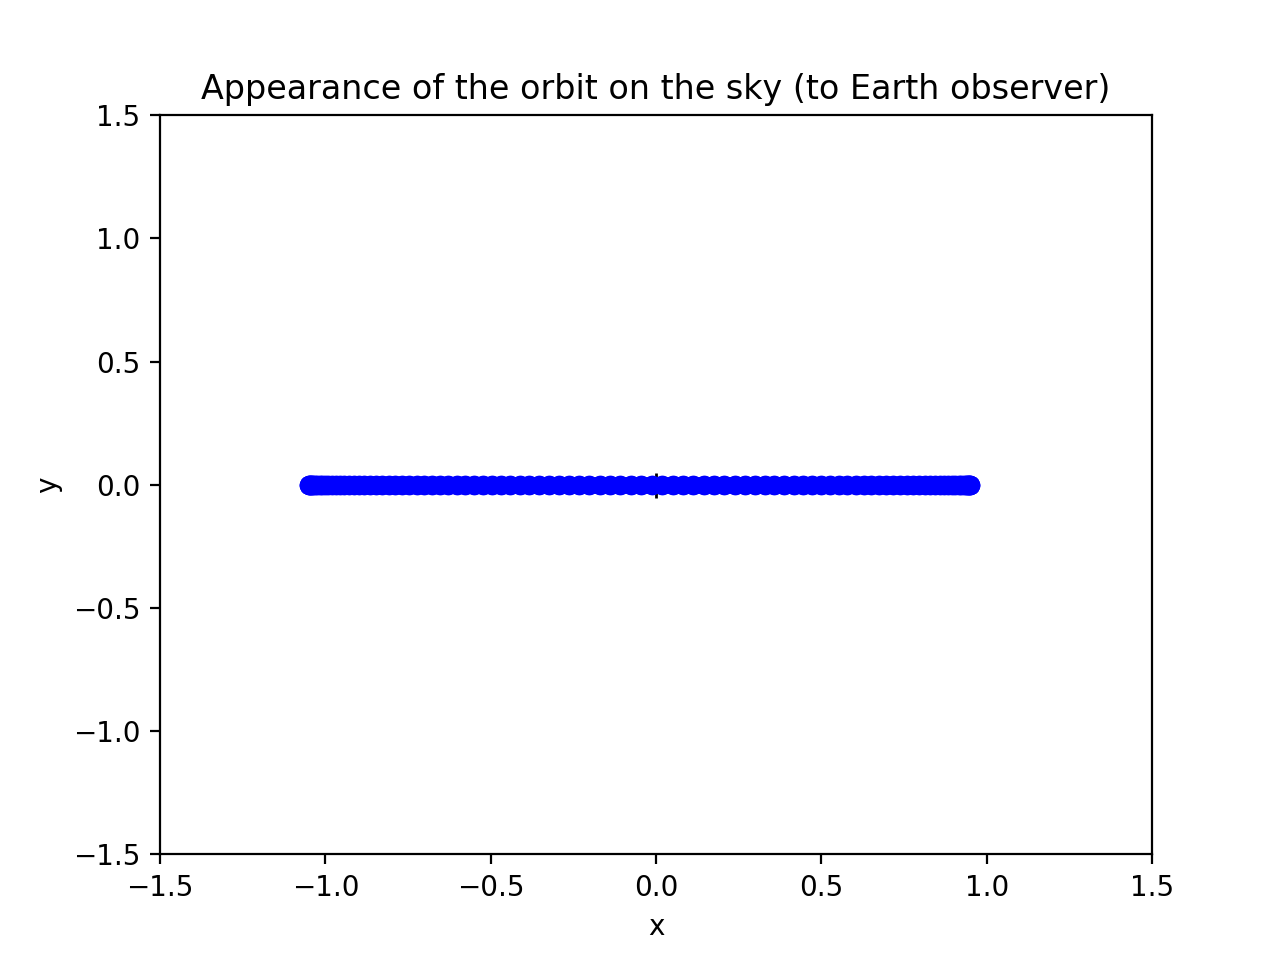

<IPython.core.display.Javascript object>


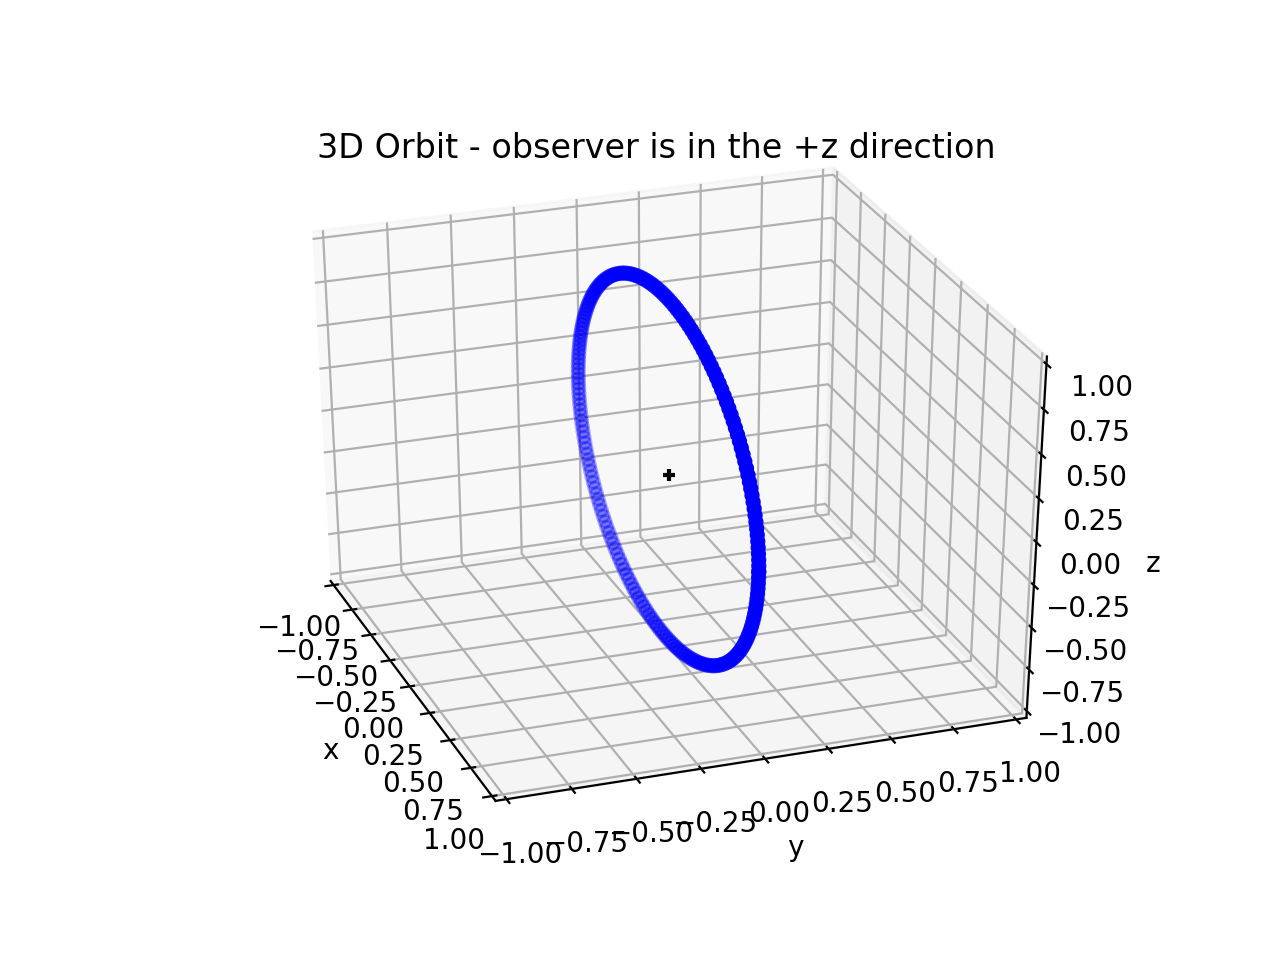

Text(0.5, 0, 'z')

In [36]:
# Plot x and y coordinates of the orbit
#NOTE: x is index = 1 and y is index = 0 because of North and East conventions - z is still 2

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.title("Appearance of the orbit on the sky (to Earth observer)")
plt.plot([0], [0], 'k+', markersize=9)
plt.plot(pos[::, 0], pos[::, 1], 'bo')

plt.figure()
ax = plt.axes(projection='3d')
ax.set_title("3D Orbit - observer is in the +z direction")
ax.scatter(0, 0, 0, color='black', marker='+')
ax.scatter3D(pos[::, 0], pos[::, 1], pos[::, 2], color='blue')

ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
ax.set_zlim((-1,1))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

### Calculating the drift rate at each position

Remember that a drift rate is caused by a change in radial velocity (aka. a change in Doppler shift). One way to calculate the change in velocity, i.e., the acceleration, is to select the velocity vectors at each i and i+1 timesteps and take their difference, giving you an approximation for the acceleration at i. There is a function in PyAstronomy to get velocities at each point, if we wanted to do it that way. 

However, in these systems, the planetary environment is dominated by a single force: gravity from the host star. So any acceleration *must* come from F_gravitational. Which means we don't need to mess with the velocities at all: we can just calculate a_gravitational at each position, and we've got our acceleration vector! To get a_gravitational, all we need is the mass of the host star (which we added to a cell waaaay back at the top of the notebook) and the distance between the star and the planet at each position. We could calculate that pretty easily from the positions, but there's actually a built-in function ``radius`` that will do it for us.

In [37]:
# Calculate orbit radius as a function of time
radius = ke.radius(t)

#remember to bring the AU units in, because PyAstronomy didn't like them before
total_acceleration = const.G * stellar_mass / (radius * u.AU)**2.0

print(total_acceleration.si)

[0.00657073 0.00657035 0.0065692  0.0065673  0.00656463 0.00656122
 0.00655705 0.00655215 0.00654652 0.00654017 0.00653311 0.00652536
 0.00651693 0.00650783 0.00649808 0.00648769 0.00647669 0.0064651
 0.00645293 0.0064402  0.00642694 0.00641316 0.0063989  0.00638416
 0.00636898 0.00635338 0.00633738 0.00632101 0.00630429 0.00628725
 0.0062699  0.00625228 0.00623441 0.00621631 0.00619801 0.00617952
 0.00616089 0.00614212 0.00612324 0.00610427 0.00608524 0.00606616
 0.00604707 0.00602798 0.0060089  0.00598987 0.00597089 0.005952
 0.0059332  0.00591452 0.00589597 0.00587757 0.00585933 0.00584128
 0.00582342 0.00580578 0.00578836 0.00577118 0.00575425 0.00573758
 0.00572119 0.00570509 0.00568929 0.0056738  0.00565862 0.00564378
 0.00562927 0.00561511 0.00560131 0.00558787 0.00557479 0.0055621
 0.00554979 0.00553787 0.00552635 0.00551522 0.00550451 0.00549421
 0.00548432 0.00547486 0.00546582 0.00545722 0.00544904 0.00544131
 0.00543401 0.00542715 0.00542074 0.00541478 0.00540927 0.00540421

Woohoo, there's the total acceleration towards the central star at each point in the orbit! We're *almost* done, but there's one last geometric issue to wrestle with. The acceleration vector points from the planet towards the host star, which means that its direction is changing relative to our line-of-sight here on Earth as the planet orbits. So to figure out the actual drift rate we would measure on Earth, we have to figure out what the *projected* acceleration is towards the Earth observer on the +z axis.

### Getting the *projected* drift rate at each position

To get vector projections, we have to use vector math aka. the dot product. The calculations in this cell only work, by the way, if the distance from the system to Earth is far greater than the semimajor axis of the exoplanet. Luckily, that will always be true for any planet that isn't in the solar system.

The unit vector pointing from the system towards the Earth is [0,0,1], due to the observer being placed on the +z axis.

So we're going to initialize an empty array of z_accelerations --- the amount of acceleration that actually happens in the Earth's direction --- and then fill it by iterating through each position and calculating the dot product between the acceleration (and position) vectors and the +z axis.

In [46]:
#initialize empty array of z_magntiudes (described below)
z_acceleration_array = []
vector_to_earth = [0,0,1]

#iterate over all positions
for i in range(0, num_timesteps):
    #vector from the origin (host star) to the point in the orbit
    position_vector = pos[i,:]
    #normalized magnitude of the vector in the observer's direction - between -1 and 1
    z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
    #acceleration observed on Earth = total acceleration * z_magnitude
    z_acceleration_array.append(z_magnitude * total_acceleration[i])

In [54]:
for zacc in z_acceleration_array:
    print(zacc.si)

0.0 m / s2
-0.0002295237346175038 m / s2
-0.0004586607200693222 m / s2
-0.0006870255272645059 m / s2
-0.0009142353583327091 m / s2
-0.001139911340012 m / s2
-0.0013636797906471608 m / s2
-0.0015851734524594905 m / s2
-0.0018040326811315387 m / s2
-0.0020199065852163195 m / s2
-0.0022324541084227803 m / s2
-0.0024413450484390533 m / s2
-0.002646261006622639 m / s2
-0.0028468962636018728 m / s2
-0.0030429585765849847 m / s2
-0.0032341698949507067 m / s2
-0.003420266991486496 m / s2
-0.0036010020074361306 m / s2
-0.003776142910306919 m / s2
-0.003945473864158133 m / s2
-0.004108795512836998 m / s2
-0.004265925177338156 m / s2
-0.004416696969129567 m / s2
-0.004560961821905465 m / s2
-0.004698587444790332 m / s2
-0.004829458200522146 m / s2
-0.004953474912585733 m / s2
-0.005070554605645616 m / s2
-0.005180630183941667 m / s2
-0.005283650052560096 m / s2
-0.0053795776866780885 m / s2
-0.005468391154004611 m / s2
-0.005550082595705244 m / s2
-0.005624657671108812 m / s2
-0.00569213497145186

Now we just convert from accelerations to drift rates, and we're done!

In [56]:
final_drift_array = []
for i in range(0, num_timesteps):
    final_drift = (z_acceleration_array[i] / const.c).si.value #get rid of the units for plotting, now that we've done the hard part
    #print(final_drift.si)
    final_drift_array.append(final_drift)

If you wanted to get the maximum drift rate, a la Sheikh et al. 2019, you can just take the maximum of this array (with an absolute value, to catch negative drift rates too)

In [57]:
print(np.max(np.abs(final_drift_array) * u.Hz))

1.997610088020196e-11 Hz


### Visualizing the final drift rates in our system

Let's plot the change in drift rate over the orbit!

<IPython.core.display.Javascript object>


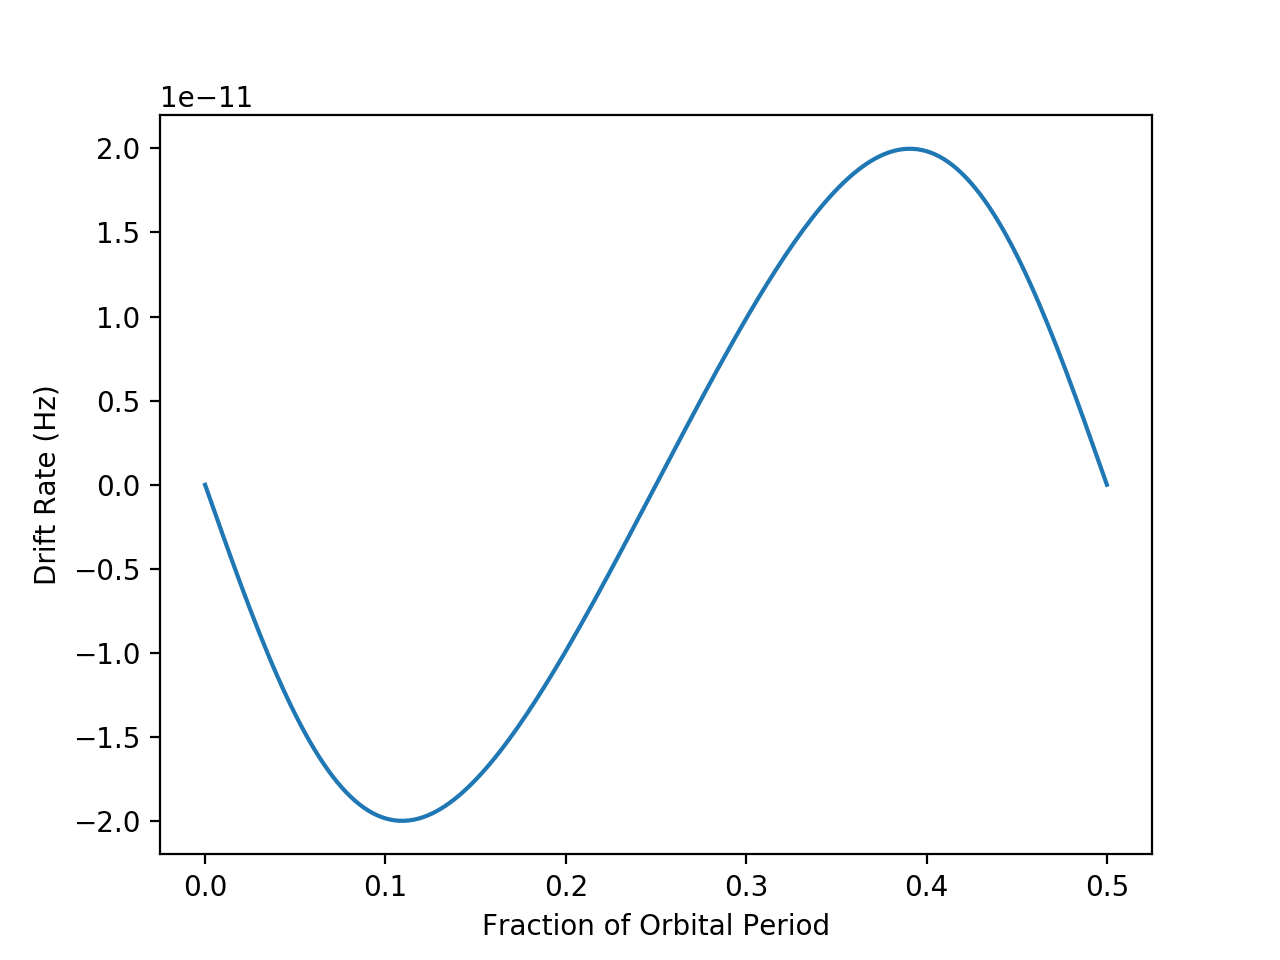

In [58]:
plt.figure()
plt.xlabel('Fraction of Orbital Period')
plt.ylabel('Drift Rate (Hz)')
plt.plot(t/2, final_drift_array)

For circular or near-circular orbits, the drift rate curve will look like a sinusoid. Higher eccentricities should make it progressively more skewed.

Finally, let's plot a histogram, to get an idea of what the drift rate distribution looks like for this single system.

<IPython.core.display.Javascript object>


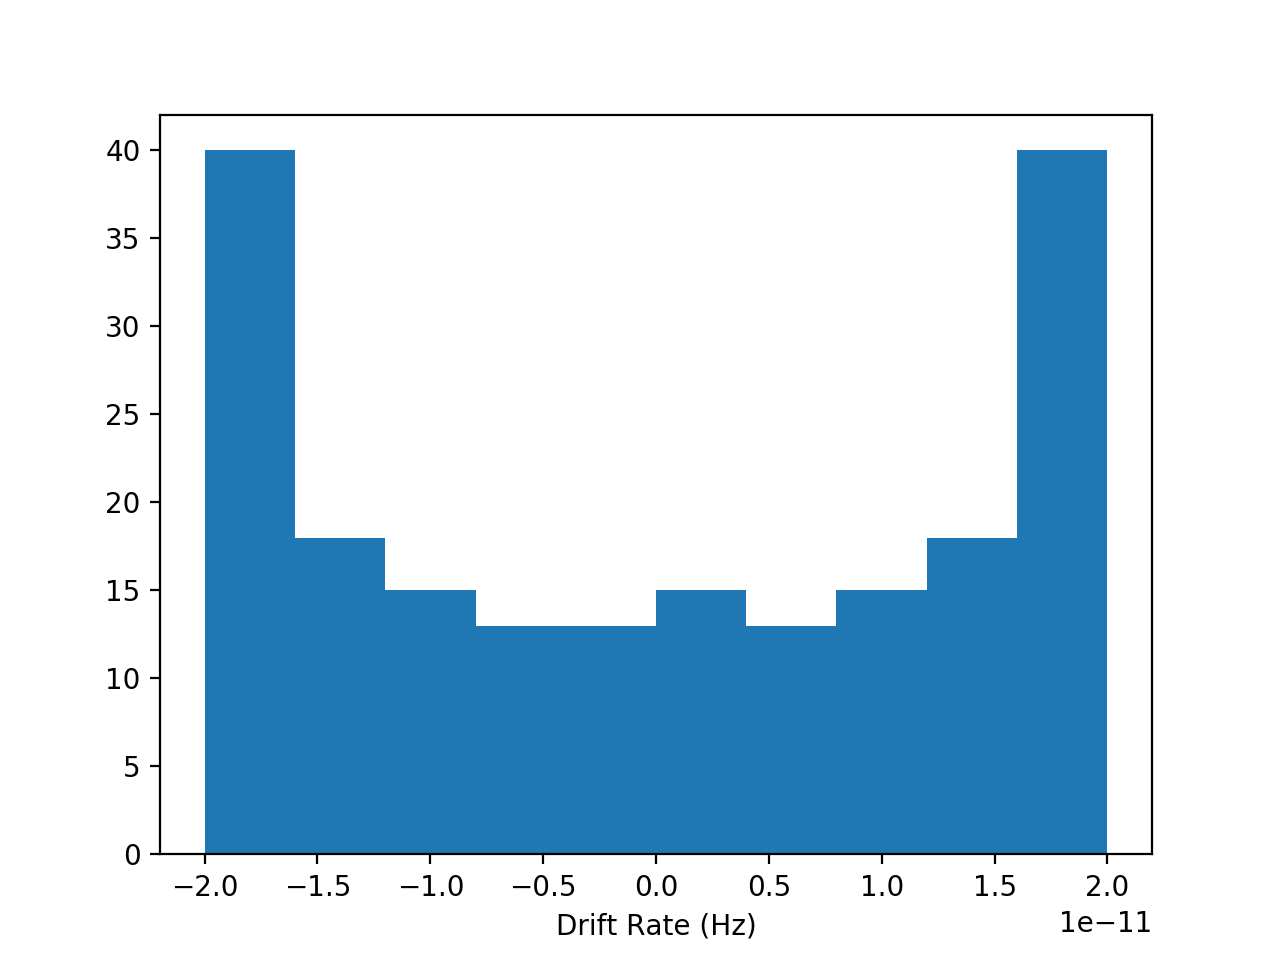

Text(0.5, 0, 'Drift Rate (Hz)')

In [59]:
plt.figure()
plt.hist(final_drift_array)
plt.xlabel('Drift Rate (Hz)')

## Your task(s)!

- Make each of the "steps" in this notebook into their own Python functions, and then make a main function to run them all. 
    - The main function should have inputs of the system parameters and timestep, and output a position array and a drift rate array
    - Make separate plotting functions for each of the three plots in this notebook, that take in the position array / drift rate array and display (and optionally save) the plot
    
- Once you have the functions working with the example data, try varying one exoplanetary system parameter at a time while holding everything else constant. Run a lot of different experiments, including:
    - Varying eccentricities: e=[0, 0.5, 0.99]
    - Varying semimajor axis: Try Earth, Jupiter, and a planet with a small semimajor axis (maybe one of the TRAPPIST-1 planets) -> remember that you have to also put in the correct period when you change this parameter
    - Vary inclination i =[-90,0,45,90]
    - Vary argument of periapse and longitude of ascending node and try to understand how they're defined and how they affect the plots and the output (I don't have suggestions for values here because I'm not sure!)
    
- Finally, try finding a real exoplanet in an exoplanet database and tracking down all of the necessary parameters to model it with this code. Real data is trickier! Things to keep in mind:
    - Make sure that the way that they're defining each parameter (units, but especially the direction and definition of angles) is the same as the way that the code is defining it
    - Keep in mind that these sorts of angles may not be provided in the "standard" set of columns for a database, so you may have to do some digging to track them down 
    - Think about what you will do if one of these parameters (probably the angular ones) is unknown for a certain target? How could you decide what value to use instead? What will you do if they provide error bars? (we'll talk about this in-depth next week!)